 Download and Plot Dataset

Files already downloaded and verified
Files already downloaded and verified


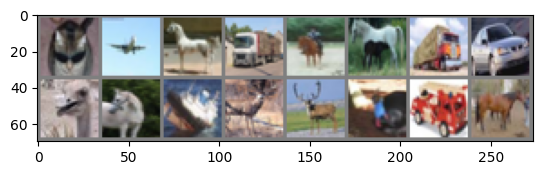

cat plane horse truck horse horse truck car bird horse ship deer deer bird truck horse


In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))

print(' '.join(classes[labels[j]] for j in range(16)))


Define the Model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardNN(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_layers=[128, 64], output_size=10):
        super(FeedForwardNN, self).__init__()
        layers = []
        in_features = input_size


        for hidden in hidden_layers:
            layers.append(nn.Linear(in_features, hidden))
            layers.append(nn.ReLU())
            in_features = hidden


        layers.append(nn.Linear(in_features, output_size))
        layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


 Implement Backpropagation and Optimizers. code for training function

In [12]:
import torch.optim as optim

def train_model(model, criterion, optimizer, trainloader, epochs=10):
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

    print('Training Complete')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = FeedForwardNN(hidden_layers=[128, 64]).to(device)


criterion = nn.CrossEntropyLoss()


optimizer_sgd = optim.SGD(model.parameters(), lr=0.01)
optimizer_momentum = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_nesterov = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001)
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)


train_model(model, criterion, optimizer_adam, trainloader, epochs=5)


Epoch 1, Loss: 2.1047678328704835
Epoch 2, Loss: 2.0716356173706054
Epoch 3, Loss: 2.0620265795898436
Epoch 4, Loss: 2.0651943186187744
Epoch 5, Loss: 2.0602323399353026
Training Complete


Evaluate Model and Tune Hyperparameters

In [13]:
def evaluate_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')


evaluate_model(model, testloader)


Accuracy: 40.94%


Plotting the confusion matrix

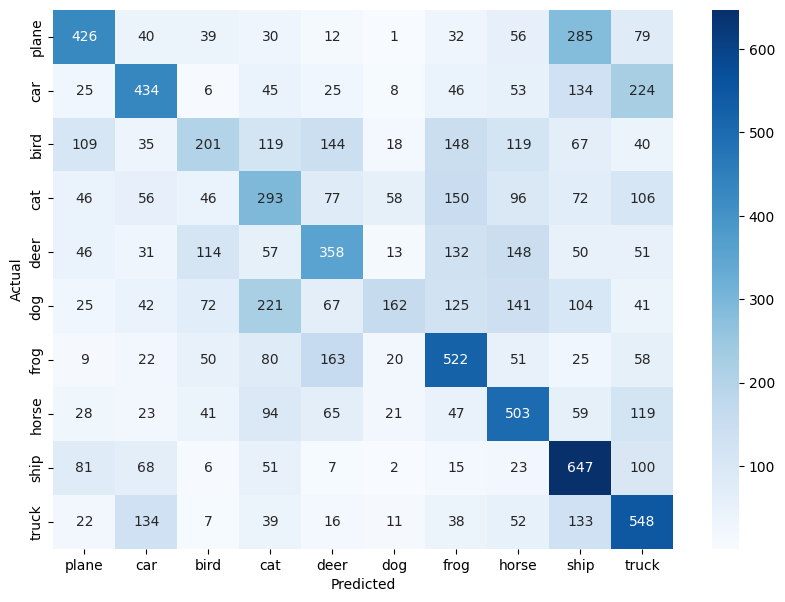

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confusion_matrix(model, testloader):
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


plot_confusion_matrix(model, testloader)


 Compare Loss Functions

In [16]:
def train_with_loss_function(model, criterion, optimizer, trainloader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)

            if isinstance(criterion, nn.MSELoss):
                labels_one_hot = torch.zeros(outputs.shape).to(device)
                labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
                loss = criterion(outputs, labels_one_hot)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")


model_ce = FeedForwardNN()
model_mse = FeedForwardNN()


criterion_ce = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()


optimizer = optim.Adam(model_ce.parameters(), lr=0.001)


print("Training with Cross-Entropy Loss:")
train_with_loss_function(model_ce, criterion_ce, optimizer, trainloader)

print("\nTraining with Mean Squared Error (MSE) Loss:")
train_with_loss_function(model_mse, criterion_mse, optimizer, trainloader)



Training with Cross-Entropy Loss:
Epoch 1, Loss: 2.1158
Epoch 2, Loss: 2.0781
Epoch 3, Loss: 2.0661
Epoch 4, Loss: 2.0688
Epoch 5, Loss: 2.0672

Training with Mean Squared Error (MSE) Loss:
Epoch 1, Loss: 0.0901
Epoch 2, Loss: 0.0901
Epoch 3, Loss: 0.0901
Epoch 4, Loss: 0.0901
Epoch 5, Loss: 0.0901
